In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import pathlib
import numpy as np
import pandas as pd

dim = 16
directory = pathlib.Path("../events/MG3")

df3b = pd.read_hdf(directory / "dataframes" / "bbbj.h5")
df4b = pd.read_hdf(directory / "dataframes" / "bbbb_large.h5")

In [3]:
import sys
sys.path.append("/home/soheuny/HH4bsim/python/classifier/")
from symmetrize_df import symmetrize_df

df3b = symmetrize_df(df3b)
df4b = symmetrize_df(df4b)

In [4]:
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from symmetrized_model_train import symmetrizedModelParameters

model_config = "FvT_ResNet_6_6_6_np799_lr0.01_epochs30_stdscale_epoch30_loss0.6703.pkl"

model_filename = f"/home/soheuny/HH4bsim/python/classifier/FvT/fvt_fit/archive/{model_config}"
clf = symmetrizedModelParameters(df3b, df4b, fileName=model_filename)

features = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
            "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
            "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
            "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

X_train = torch.tensor(clf.df_train[features].values, dtype=torch.float32)
X_validation = torch.tensor(clf.df_val[features].values, dtype=torch.float32)

y_train = torch.tensor(clf.df_train["d4"].values, dtype=torch.float32)
y_validation = torch.tensor(clf.df_val["d4"].values, dtype=torch.float32)

torch.cuda.is_available() True
Found CUDA device cuda 1 NVIDIA GeForce RTX 4090
Add true class labels to data
concatenate data and ttbar dataframes
add encoded target
nd4 =  382108, wd4 = 385679.3
nd3 =  275508, wd3 = 279203.5
fC: tensor([0.5801, 0.4199])
build idx with offset 0, modulus 3, and train/val split 2
Split into training and validation sets
--------------- LRINIT:  0.01
cuda
Set log file: log_file.log
SymmetrizedResNet(
  (canJetScaler): scaler()
  (dijetScaler): scaler()
  (quadjetScaler): scaler()
  (jetPtGBN): GhostBatchNorm1d()
  (jetEtaGBN): GhostBatchNorm1d()
  (jetMassGBN): GhostBatchNorm1d()
  (jetEmbed): conv1d(
    (module): Conv1d(4, 6, kernel_size=(1,), stride=(1,))
  )
  (dijetGBN): GhostBatchNorm1d()
  (dijetEmbed1): conv1d(
    (module): Conv1d(2, 6, kernel_size=(1,), stride=(1,))
  )
  (dijetResNetBlock): dijetResNetBlock(
    (reinforce1): dijetReinforceLayer(
      (conv): conv1d(
        (module): Conv1d(6, 6, kernel_size=(3,), stride=(3,), bias=False)
   

In [5]:
from fvt_eval import calculate_fvt_values

loss, grads, scores = calculate_fvt_values(clf, clf.df_val)
# ResNet predictions
probs_4b_sym_resnet = torch.softmax(scores, dim=1)[:, 1].detach()
# cross check
weights = clf.df_val[clf.weight].values
loss_val_crosscheck = -torch.sum((torch.log(probs_4b_sym_resnet) * y_validation 
                               + torch.log(1 - probs_4b_sym_resnet) * (1 - y_validation)) * weights) / np.sum(weights)

print("SymResNet Validation Loss: ", loss)
print("SymResNet Validation Loss Cross check: ", loss_val_crosscheck)

# without gradients
# X_validation = torch.cat((X_validation, probs_4b_sym_resnet.reshape(-1, 1)), dim=1)

# with gradients
# remove the gradient of sym_canJet0_phi
# grads = grads[:, np.arange(grads.shape[1]) != 8]
# X_validation = torch.cat((X_validation, probs_4b_sym_resnet.reshape(-1, 1), 
#                           grads.reshape(-1, X_validation.shape[1])), dim=1)

# weights
w_validation = torch.tensor(weights, dtype=torch.float32)
# add sym_canJet0_phi
X_validation = torch.cat((X_validation[:, :8], torch.zeros_like(X_validation[:, :1]), X_validation[:, 8:]), dim=1)

torch.cuda.is_available() True
Found CUDA device cuda 1 NVIDIA GeForce RTX 4090
SymResNet Validation Loss:  0.6703050996648615
SymResNet Validation Loss Cross check:  tensor(0.6703)


In [6]:
print(X_validation.shape)
print(w_validation.shape)

torch.Size([219205, 16])
torch.Size([219205])


In [7]:
from variational_autoencoder import VariationalAutoencoder
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

pl.seed_everything(42)

# split X_validation into training and validation
random_indices = torch.randperm(len(X_validation))

# For ghostbatch, let len(train_indices) be a multiple of 32
split_at = 32 * (int((2/3) * len(X_validation)) // 32)
end_at = 32 * (len(X_validation) // 32)

train_indices = random_indices[:split_at]
validation_indices = random_indices[split_at:end_at]

X_ae_train = X_validation[train_indices]
X_ae_validation = X_validation[validation_indices]
y_ae_train = y_validation[train_indices]
y_ae_validation = y_validation[validation_indices]
w_ae_train = w_validation[train_indices]
w_ae_validation = w_validation[validation_indices]

ae_train_dataset = TensorDataset(X_ae_train, w_ae_train)
ae_validation_dataset = TensorDataset(X_ae_validation, w_ae_validation)


hidden_dims = [256] * 4

# features = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
#             "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
#             "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
#             "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]


likelihood_configs = [
    # pt
    {"type": "TruncatedGaussian", "lb": 0}, 
    {"type": "TruncatedGaussian", "lb": 0},
    {"type": "TruncatedGaussian", "lb": 0},
    {"type": "TruncatedGaussian", "lb": 0},
    # eta
    {"type": "TruncatedGaussian", "lb": 0, "ub": 2.5},
    {"type": "TruncatedGaussian", "lb": -2.5, "ub": 2.5},
    {"type": "TruncatedGaussian", "lb": -2.5, "ub": 2.5},
    {"type": "TruncatedGaussian", "lb": -2.5, "ub": 2.5},
    # phi
    {"type": "TruncatedGaussian", "lb": 0, "ub": 0.1}, # sym_canJet0_phi should be 0
    {"type": "TruncatedGaussian", "lb": 0, "ub": torch.pi},
    {"type": "TruncatedGaussian", "lb": -torch.pi, "ub": torch.pi},
    {"type": "TruncatedGaussian", "lb": -torch.pi, "ub": torch.pi},
    # m
    {"type": "Gaussian"},
    {"type": "Gaussian"},
    {"type": "Gaussian"},
    {"type": "Gaussian"},
]

Seed set to 42


In [21]:
for lr in [1e-4]:
    for beta in [0.5]:
        for latent_dim in [4]:
            encoder_config = {
                "type": "MLPEncoder",
                "input_dim": X_validation.shape[1],
                "hidden_dims": hidden_dims[:-1],
                "latent_dim": hidden_dims[-1],
                "name": "mlp",
            }
            # encoder_config = {
            #     "type": "FvTEncoder", 
            #     "dim_input_jet_features": 4, 
            #     "dim_intermed_dijet_features": 128,
            #     "dim_intermed_quadjet_features": 128,
            #     "dim_output": 128,
            #     "name": "fvt",
            # }
            decoder_config = {
                "type": "MLPDecoder",
                "latent_dim": latent_dim,
                "hidden_dims": hidden_dims[::-1],
                "output_dim": X_validation.shape[1],
            }
            model = VariationalAutoencoder(
                                input_dim=X_validation.shape[1], 
                                latent_dim=latent_dim, 
                                run_name=f"{encoder_config['name']}_vae_latent_dim={latent_dim}_beta={beta}_lr={lr}",
                                encoder_config=encoder_config,
                                decoder_config=decoder_config,
                                likelihood_configs=likelihood_configs,
                                lr=lr, 
                                beta=beta)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device)
            model.fit(ae_train_dataset, ae_validation_dataset, batch_size=2**10, max_epochs=80)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/soheuny/HH4bsim/playground/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type       | Params
--------------------------------------------------
0 | encoder            | MLPEncoder | 201 K 
1 | decoder            | MLPDecoder | 202 K 
2 | encoder_activation | Activation | 0     
3 | mu_encoder         | Linear     | 1.0 K 
4 | logvar_encoder     | Linear     | 1.0 K 
5 | ll_params_decoders | ModuleList | 544   
  | other params       | n/a        | 24    
--------------------------------------------------
406 K     Trainable params
0         Non-trainable params
406 K     Total params
1.627     Total estimated model params size (M

Epoch 79: 100%|██████████| 143/143 [00:03<00:00, 40.14it/s, v_num=9, val_loss=8.530, val_kl=1.360, val_ll=-15.7, train_loss=8.620]  

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 143/143 [00:03<00:00, 40.10it/s, v_num=9, val_loss=8.530, val_kl=1.360, val_ll=-15.7, train_loss=8.620]


In [22]:
latent_dim = 4
beta = 0.5
lr = 1e-4

In [23]:
run_name = f"mlp_vae_latent_dim={latent_dim}_beta={beta}_lr={lr}"
model_checkpoint_path = f"./checkpoints/{run_name}_best-v1.ckpt"
model = VariationalAutoencoder.load_from_checkpoint(checkpoint_path=model_checkpoint_path)
device = torch.device("cuda")
model = model.to(device)

model.eval()
val_dataloader = DataLoader(ae_validation_dataset, batch_size=1024, shuffle=False, num_workers=4)

X_ae_validation_encoded_np = np.array([])
X_ae_validation_reconstructed_np = np.array([])

for x, w in val_dataloader:
    x = x.to(device)
    x_encoded_mu = model.encode(x)[0].detach().cpu().numpy()
    X_ae_validation_encoded_np = (
        x_encoded_mu
        if len(X_ae_validation_encoded_np) == 0
        else np.concatenate((X_ae_validation_encoded_np, x_encoded_mu), axis=0)
    )

    x_recontstructed = model.reconstruct(x).detach().cpu().numpy()
    X_ae_validation_reconstructed_np = (
        x_recontstructed
        if len(X_ae_validation_reconstructed_np) == 0
        else np.concatenate(
            (X_ae_validation_reconstructed_np, x_recontstructed), axis=0
        )
    )


X_ae_validation_np = X_ae_validation.detach().cpu().numpy()
y_ae_validation_np = y_ae_validation.detach().cpu().numpy()

In [24]:
l1 = 0
l2 = 1
f1 = 10
f2 = 11

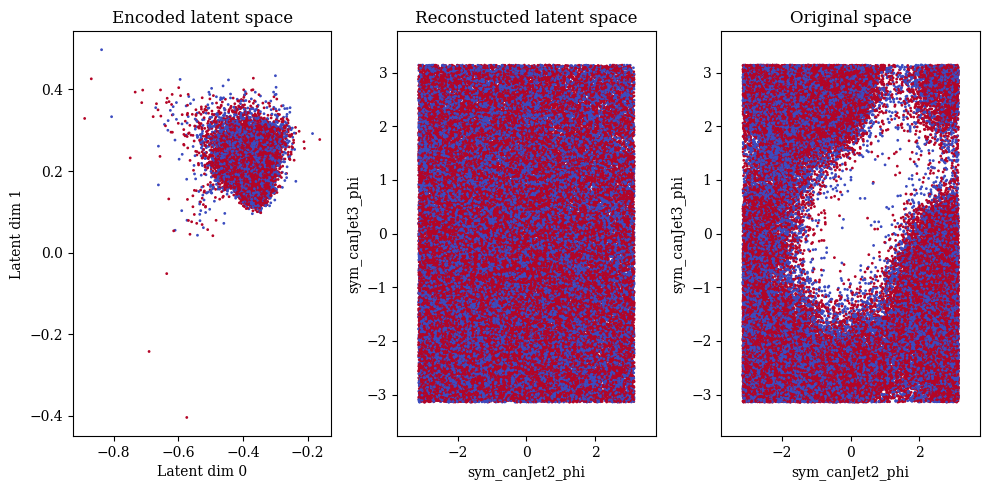

In [25]:
# plot latent space

features_tmp = ["sym_canJet0_pt", "sym_canJet1_pt", "sym_canJet2_pt", "sym_canJet3_pt",
                "sym_canJet0_eta", "sym_canJet1_eta", "sym_canJet2_eta", "sym_canJet3_eta",
                "sym_canJet0_phi", "sym_canJet1_phi", "sym_canJet2_phi", "sym_canJet3_phi",
                "sym_canJet0_m", "sym_canJet1_m", "sym_canJet2_m", "sym_canJet3_m"]

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

%matplotlib inline
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.scatter(X_ae_validation_encoded_np[:, l1], X_ae_validation_encoded_np[:, l2], 
            c=y_ae_validation_np, cmap="coolwarm", s=1)
plt.xlabel(f"Latent dim {l1}")
plt.ylabel(f"Latent dim {l2}")
plt.title("Encoded latent space")

xmin, xmax = X_ae_validation_reconstructed_np[:, f1].min(), X_ae_validation_reconstructed_np[:, f1].max()
xmin, xmax = min(xmin, X_ae_validation_np[:, f1].min()), max(xmax, X_ae_validation_np[:, f1].max())
ymin, ymax = X_ae_validation_reconstructed_np[:, f2].min(), X_ae_validation_reconstructed_np[:, f2].max()
ymin, ymax = min(ymin, X_ae_validation_np[:, f2].min()), max(ymax, X_ae_validation_np[:, f2].max())
x_diff = xmax - xmin
y_diff = ymax - ymin
xmin, xmax = xmin - 0.1 * x_diff, xmax + 0.1 * x_diff
ymin, ymax = ymin - 0.1 * y_diff, ymax + 0.1 * y_diff

plt.subplot(132)
plt.scatter(X_ae_validation_reconstructed_np[:, f1], X_ae_validation_reconstructed_np[:, f2], 
            c=y_ae_validation_np, cmap="coolwarm", s=1)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.xlabel(f"{features_tmp[f1]}")
plt.ylabel(f"{features_tmp[f2]}")
plt.title("Reconstucted latent space")

plt.subplot(133)
plt.scatter(X_ae_validation_np[:, f1], X_ae_validation_np[:, f2], 
            c=y_ae_validation_np, cmap="coolwarm", s=1)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title("Original space")
plt.xlabel(f"{features_tmp[f1]}")
plt.ylabel(f"{features_tmp[f2]}")
plt.tight_layout()
plt.show()
plt.close()